In [1]:
# !pip install transformers
# !pip install emoji
# !pip install sentencepiece 

In [1]:
import torch
import json
import random
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
#from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [2]:
def fix_the_random(seed_val = 42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [3]:
fix_the_random(2021)

In [4]:
veParams={
    'path_files': './BERTBASED/',
    'what_bert':'weighted',
    'batch_size':24,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':1,
    'to_save':True,
    'weights':[0.53,0.47],
    'frac':0.8,
    'outputDir':'./BERT_CODE_BERT/'
}

In [5]:
def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c, 
            'precision': precisionScore, 'recall': recallScore}



def getFeaturesandLabel(X,y, text_features, code_features):
    X_text_data = []
    X_code_data = []
    for i in X:
        X_text_data.append(text_features[i])
        X_code_data.append(code_features[i])
    X_text_data = torch.tensor(X_text_data)
    X_code_data = torch.tensor(X_code_data)
    y_data = torch.tensor(y)
    return X_text_data, X_code_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
import pandas as pd
trainData = pd.read_csv("train_val_soft.csv")

In [7]:
def changeToLabel(text):
    if text =='Useful':
        return 1
    else:
        return 0

In [8]:
trainData['label'] = trainData['Class'].map(changeToLabel)

In [9]:
trainData.head()

,Comments,Surrounding Code Context,Class,ids,label
0,/*test 529*/,-10. int res = 0;\n-9. CURL *curl = NULL;\...,Not Useful,0,0
1,/*test 525*/,"-2. fprintf(stderr, ""Usage: lib529 [url] [...",Not Useful,1,0
2,/*done*/,"-10. multi_add_handle(m, curl);\n-9. for(;...",Not Useful,2,0
3,/*test 529*/,-10. int res = 0;\n-9. CURL *curl = NULL;\...,Not Useful,3,0
4,/*test 525*/,"-2. fprintf(stderr, ""Usage: lib529 [url] [...",Not Useful,4,0


In [10]:
X, y  = list(trainData['ids']), list(trainData['label'])

In [11]:
from sklearn.model_selection import train_test_split

# given:
# features: xs
# ground truth: ys

X_tn, X_v, y_tn, y_v = train_test_split(X, y, test_size=0.15, random_state=2021, stratify=y)

In [12]:
testData = pd.read_csv("test_soft.csv")

In [13]:
len(testData)

1001

In [14]:
testData['label'] = testData['Class'].map(changeToLabel)

In [15]:
X_ts = list(testData['ids'])
y_ts = list(testData['label'])

In [16]:
import pickle
with open('text_bert_embedding.p', 'rb') as fp:
    textDataEmb = pickle.load(fp)

with open('code_bert_embedding.p', 'rb') as fp:
    codeDataEmb = pickle.load(fp)

In [17]:
X_train_text, X_train_code, y_train = getFeaturesandLabel(X_tn,y_tn, textDataEmb, codeDataEmb)
X_val_text, X_val_code, y_val = getFeaturesandLabel(X_v,y_v, textDataEmb, codeDataEmb)
X_test_text, X_test_code, y_test = getFeaturesandLabel(X_ts,y_ts, textDataEmb, codeDataEmb)

/home/mithun-binny/anaconda3/envs/hate_meme/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [18]:
BATCH_SIZE = 32
#Dataset wrapping tensors.
train_data = TensorDataset(X_train_text, X_train_code, y_train)
val_data = TensorDataset(X_val_text, X_val_code, y_val)
test_data = TensorDataset(X_test_text, X_test_code, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Uni_Model(nn.Module):
    def __init__(self, input_size, fc1_hidden, fc2_hidden, output_size):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,fc1_hidden),
            nn.ReLU(),
            nn.Linear(fc1_hidden, fc2_hidden),
            nn.ReLU(),
            nn.Linear(fc2_hidden, output_size),
        )
    def forward(self, xb):
        return self.network(xb)


    
class Combined_model(nn.Module):
    def __init__(self, text_model, image_model, num_classes):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc_output   = nn.Linear(2*64, num_classes)
    def forward(self, x_text, x_vid):
        tex_out = self.text_model(x_text)
        vid_out = self.image_model(x_vid)
        inp = torch.cat((tex_out, vid_out), dim = 1)
        out = self.fc_output(inp)
        return out

In [20]:
import torch
import torch.nn as nn

In [21]:
input_size_text = 768
fc1_hidden_audio = 256
fc2_hidden_audio = 128
k =2
tex = Uni_Model(input_size_text, fc1_hidden_audio, fc2_hidden_audio, 64).to(device)
cde = Uni_Model(input_size_text, fc1_hidden_audio, fc2_hidden_audio,  64).to(device)
model = Combined_model(tex, cde, k).to(device)

In [22]:
model

Combined_model(
  (text_model): Uni_Model(
    (network): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (image_model): Uni_Model(
    (network): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (fc_output): Linear(in_features=128, out_features=2, bias=True)
)

In [23]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [24]:
def getPerformanceOfLoader(model,test_dataloader):
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
        #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_text_ids, b_code_ids, b_labels = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_text_ids,b_code_ids)
        
        logits = outputs.max(1, keepdim=True)[1]
        #print(logits)
        #print(logits.shape)
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    print('DONE.')

    pred = [i[0] for i in predictions]
    df = pd.DataFrame()
    df['true']=true_labels
    df['target'] = pred
    #df['score'] = proba
    return df

In [25]:
# Tell pytorch to run this model on the GPU.
model.cuda()

bestValAcc  = 0
bestValMF1  = 0
besttest_df  = None
bestEpochs = -1
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 10
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_text_ids = batch[0].to(device)
        b_code_ids = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_text_ids,b_code_ids)
        y_preds = torch.max(outputs, 1)[1]  # y_pred != output
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = F.cross_entropy(outputs, b_labels, weight=torch.FloatTensor([0.53, 0.47]).to(device))

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader) 

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()



    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
 
    val_df = getPerformanceOfLoader(model,validation_dataloader)
    origValValue, preValValue = list(val_df['true']), list(val_df['target'])
    # Report the final accuracy for this validation run.
    valMf1Score = evalMetric(origValValue, preValValue)['mF1Score']
    tempValAcc  = evalMetric(origValValue, preValValue)['accuracy']
    if (valMf1Score > bestValMF1):
        bestEpochs = epoch_i
        bestValMF1 = valMf1Score
        bestValAcc  = tempValAcc
        besttest_df = getPerformanceOfLoader(model,test_dataloader)
        torch.save(model, "./BERT_CODE_BERT/bert_code_bert_256_128")
    print("  Accuracy: {0:.2f}".format(tempValAcc))
    print("  Macro F1: {0:.2f}".format(valMf1Score))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    214.    Elapsed: 0:00:00.
  Batch    80  of    214.    Elapsed: 0:00:01.
  Batch   120  of    214.    Elapsed: 0:00:01.
  Batch   160  of    214.    Elapsed: 0:00:01.
  Batch   200  of    214.    Elapsed: 0:00:01.

  Average training loss: 0.49
  Training epcoh took: 0:00:01

Running Validation...
DONE.
DONE.
  Accuracy: 0.76
  Macro F1: 0.76
  Validation took: 0:00:00

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    214.    Elapsed: 0:00:00.
  Batch    80  of    214.    Elapsed: 0:00:00.
  Batch   120  of    214.    Elapsed: 0:00:01.
  Batch   160  of    214.    Elapsed: 0:00:01.
  Batch   200  of    214.    Elapsed: 0:00:01.

  Average training loss: 0.23
  Training epcoh took: 0:00:01

Running Validation...
DONE.
DONE.
  Accuracy: 0.76
  Macro F1: 0.76
  Validation took: 0:00:00

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    214.    Elapsed: 0:00:00.
  Batch    80  of    214.    Elapse

In [26]:
bestValMF1

0.7603941551256683

In [28]:
evalMetric(besttest_df['true'], besttest_df['target'])

{'accuracy': 0.9090909090909091,
 'mF1Score': 0.888519289537034,
 'f1Score': 0.840630472854641,
 'auc': 0.8914568105820732,
 'precision': 0.8304498269896193,
 'recall': 0.851063829787234}

In [29]:
testData['pred'] = besttest_df['target']

In [30]:
#testData.to_csv("bert_fine_tune_best_val.csv", index = False)
testData.to_csv("bert_code_bert.csv", index = False)

In [39]:
testData

,Comments,Surrounding Code Context,Class,ids,label,pred
0,/*READ_INT_FUNCTIONS*/,-5. if (png_ptr != NULL)\n-4. png_war...,Not Useful,8047,0,0
1,/*Put the chunk name into png_ptr->chunk_name.*/,"-2. png_read_data(png_ptr, buf, 8);\n-1. ...",Not Useful,8048,0,0
2,/*critical*/,"-8. png_crc_read(png_structrp png_ptr, png_byt...",Not Useful,8049,0,0
3,/*READ_iCCP|iTXt|pCAL|sCAL|sPLT|tEXt|zTXt|SEQU...,-9. {\n-8. if (warn != 0)\n-7. ...,Not Useful,8050,0,0
4,/*ZLIB_VERNUM >= 0x1240*/,#if ZLIB_VERNUM >= 0x1240\n\n/*ZLIB_VERNUM >= ...,Not Useful,8051,0,0
...,...,...,...,...,...,...
996,/*The following document where the background ...,-5. #define PNG_CMAP_NONE 0\n\n /*The fol...,Useful,9043,1,0
997,/*Do all the *safe* initialization - 'safe' me...,-1. } png_image_read_control;\n/* Do all the *...,Useful,9044,1,1
998,/*And set the rest of the structure to NULL to...,-10. * called from here must *not* call png_m...,Useful,9045,1,1
999,"/*Use png_ptr here, not info_ptr, because by e...",-8. static png_uint_32\n-7. png_image_format(p...,Useful,9046,1,0


In [32]:
evalMetric(testData['label'], testData['pred'])

{'accuracy': 0.9090909090909091,
 'mF1Score': 0.8880457693465824,
 'f1Score': 0.8395061728395063,
 'auc': 0.8893015318754377,
 'precision': 0.8350877192982457,
 'recall': 0.8439716312056738}

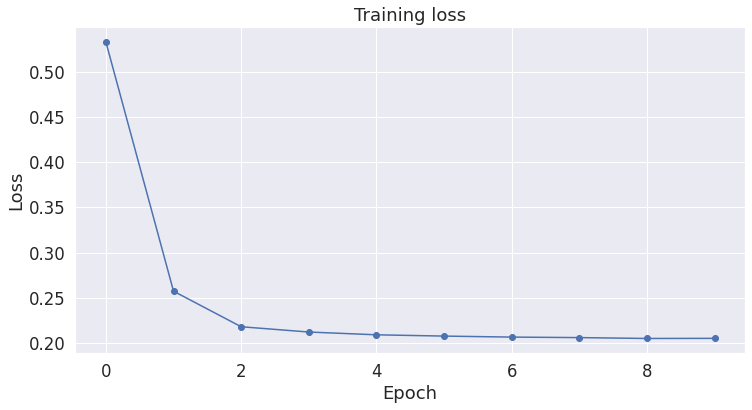

In [40]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [49]:
import re
import emoji

def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)



def preprocess_sent(sent):
    sent = re.sub(r"http\S+", "", sent)
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = re_sub(r"/", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(' +', ' ', sent)
    return sent

In [42]:
model2 = torch.load("./BERT_CODE_BERT/bert_code_bert")
model2.eval()

Combined_model(
  (text_model): Uni_Model(
    (network): Sequential(
      (0): Linear(in_features=768, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (image_model): Uni_Model(
    (network): Sequential(
      (0): Linear(in_features=768, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (fc_output): Linear(in_features=128, out_features=2, bias=True)
)

In [44]:
besttest_df2 = getPerformanceOfLoader(model2,test_dataloader)

DONE.


In [45]:
besttest_df2.head()

,true,target
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [46]:
evalMetric(besttest_df2['true'], besttest_df2['target'])

{'accuracy': 0.9090909090909091,
 'mF1Score': 0.8880457693465824,
 'f1Score': 0.8395061728395063,
 'auc': 0.8893015318754377,
 'precision': 0.8350877192982457,
 'recall': 0.8439716312056738}

In [56]:
finalLabel =[]
for index, row in testData.iterrows():
    procComm = preprocess_sent(row['Comments'])
    procCommList = procComm.split()
    if row['pred']==1 and len(procCommList)<=5:
        finalLabel.append(0)
    else:
        finalLabel.append(row['pred'])

In [59]:
evalMetric(testData['label'],finalLabel)

{'accuracy': 0.9280719280719281,
 'mF1Score': 0.9073948439620082,
 'f1Score': 0.8636363636363636,
 'auc': 0.8917379338916345,
 'precision': 0.926829268292683,
 'recall': 0.8085106382978723}

In [60]:
testData['pred_fin'] = finalLabel

In [61]:
testData.to_csv("bert_code_bert_with_5_token.csv", index = False)